In [20]:
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

file_pattern = "data/MBTA-Bus-Arrival-Departure-Times_2024-*.csv"
csv_files = sorted(glob.glob(file_pattern))

print(csv_files)

['data/MBTA-Bus-Arrival-Departure-Times_2024-02.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-03.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-04.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-05.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-06.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-07.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-08.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-09.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-10.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-11.csv', 'data/MBTA-Bus-Arrival-Departure-Times_2024-12.csv']


In [16]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"])

        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.strftime("%H:%M:%S")
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.strftime("%H:%M:%S")

        chunk["scheduled"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["scheduled"])
        chunk["actual"] = pd.to_datetime(chunk["service_date"].dt.date.astype(str) + " " + chunk["actual"])

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        total_lateness_per_route = chunk.groupby("route_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("route_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)


Processing MBTA-Bus-Arrival-Departure-Times_2024-01.csv in chunks...


Processing 2024-01: 5it [00:37,  7.54s/it]


In [17]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)
final_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["route_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("incorrect_final_summary.csv", index=False)


### Data Visualization for Obvious Outliers
We do basic graphing to see if there were any with the calculations and see that there are obvious outliers. Rather than throwing them away, we should try to see what's causing this

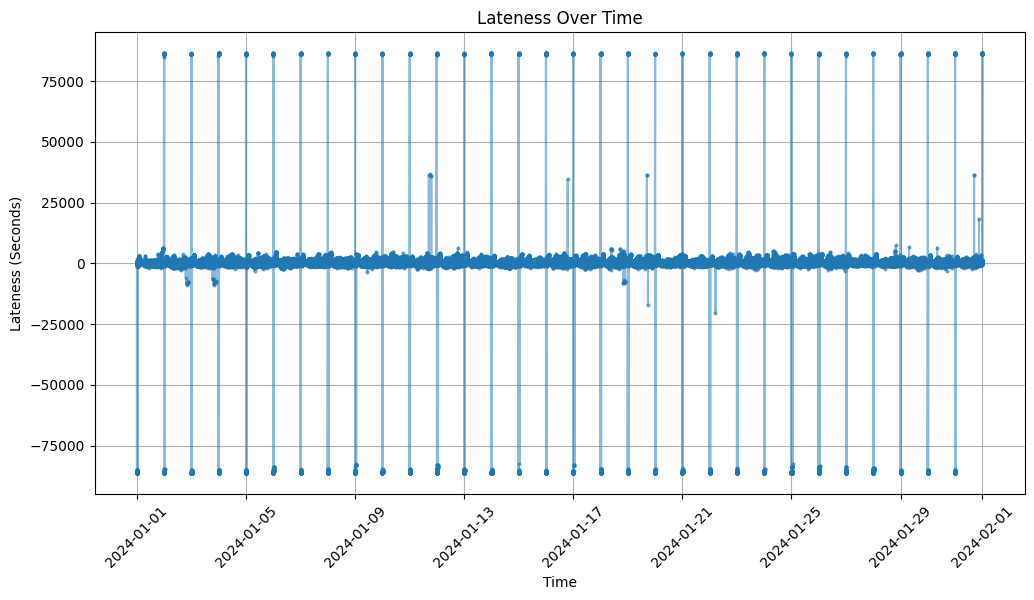

In [5]:
lateness_df = pd.DataFrame({"timestamp": timestamps, "lateness": lateness_over_time})
lateness_df = lateness_df.sort_values(by="timestamp")
plt.figure(figsize=(12, 6))
plt.plot(lateness_df["timestamp"], lateness_df["lateness"], linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Lateness (Seconds)")
plt.title("Lateness Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We grab the original indices from the original dataset to see what may be causing this

In [6]:
outliers_df = lateness_df[lateness_df["lateness"].abs() > 20000].reset_index()
outliers_df

,index,timestamp,lateness
0,19737,2024-01-01 00:00:01,-86339.0
1,12795,2024-01-01 00:00:01,-86099.0
2,23056,2024-01-01 00:00:04,-86216.0
3,2308,2024-01-01 00:00:07,-86333.0
4,2103,2024-01-01 00:00:10,-86330.0
...,...,...,...
3606,2193536,2024-01-31 23:59:36,86316.0
3607,2237001,2024-01-31 23:59:38,86018.0
3608,2245611,2024-01-31 23:59:43,86203.0
3609,2261649,2024-01-31 23:59:46,86326.0


We see from below that the reason for the outliers was for trains that was expected arrive right before midnight and arrived right after midnight. This causes a difference of near 86400 (number of seconds in a day) depending on when it arrived which lines up with the graph and table shown above.

In [ ]:
outlier_indices = set(outliers_df["index"].values)
original_outlier_rows = [] 
for csv_file in csv_files:
    print(f"Processing {csv_file} for outliers in chunks...")

    for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
        # Identify rows in the chunk that match the outlier indices
        matching_rows = chunk.loc[chunk.index.isin(outlier_indices)]

        if not matching_rows.empty:
            original_outlier_rows.append(matching_rows)

final_outlier_data = pd.concat(original_outlier_rows, ignore_index=True)
final_outlier_data

Processing MBTA-Bus-Arrival-Departure-Times_2024-01.csv for outliers in chunks...


,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway
0,2024-01-01,01,Inbound,61823930.0,59,Wasma,7,Midpoint,Headway,1900-01-02T00:00:00Z,1900-01-01T23:55:57Z,960.0,1123.0
1,2024-01-01,01,Inbound,61823930.0,62,Melwa,8,Midpoint,Headway,1900-01-02T00:04:00Z,1900-01-01T23:59:17Z,960.0,1112.0
2,2024-01-01,01,Inbound,61823930.0,64,nubn,9,Endpoint,Headway,1900-01-02T00:05:00Z,1900-01-01T23:59:39Z,960.0,1102.0
3,2024-01-01,01,Outbound,61823939.0,97,mit,6,Midpoint,Headway,1900-01-01T23:55:00Z,1900-01-02T00:00:39Z,1080.0,1351.0
4,2024-01-01,08,Outbound,61824079.0,64,nubn,6,Midpoint,Schedule,1900-01-01T23:58:00Z,1900-01-02T00:00:16Z,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606,2024-01-31,SL2,Outbound,62144512.0,74613,wtcst,3,Midpoint,Headway,1900-01-01T23:53:00Z,1900-01-02T00:01:09Z,960.0,1029.0
3607,2024-01-31,SL2,Outbound,62144512.0,74624,conrd,4,Midpoint,Headway,1900-01-01T23:55:00Z,1900-01-02T00:02:41Z,960.0,1004.0
3608,2024-01-31,SL2,Outbound,62144512.0,30250,drdck,5,Endpoint,Headway,1900-01-01T23:58:00Z,1900-01-02T00:05:18Z,960.0,1046.0
3609,2024-01-31,SL5,Inbound,62145013.0,49001,Templ,5,Endpoint,Headway,1900-01-02T00:02:00Z,1900-01-01T23:59:50Z,1200.0,1361.0


We write a refined version of data extraction of the above steps to handle the case where the days are different

In [18]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"]).dt.tz_localize(None)
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.tz_localize(None)
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.tz_localize(None)

        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)

        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()

        total_lateness_per_route = chunk.groupby("route_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("route_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)


Processing MBTA-Bus-Arrival-Departure-Times_2024-01.csv in chunks...


Processing 2024-01: 5it [00:18,  3.62s/it]


In [19]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)
final_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["route_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("unfiltered_final_summary.csv", index=False)


### Outlier Analysis (Post Data Cleaning)

If we look at the new outliers, we see that many outliers are grouped together, if we see that a bus is late by 10 hours (most likely due to maintenance, accidents, etc), it will cause all other buses on the same route to be equally late, signifying that the schedule was most likely shifted but was not reflected in the database as the intervals between the late buses remain similar. For these buses, I decided to arbitrarily not mark any bus arrivals later or earlier than an hour to be accidents or schedule shifts (perhaps we can look for a better outlier detection model). But we also see certain routes have much more outliers than others

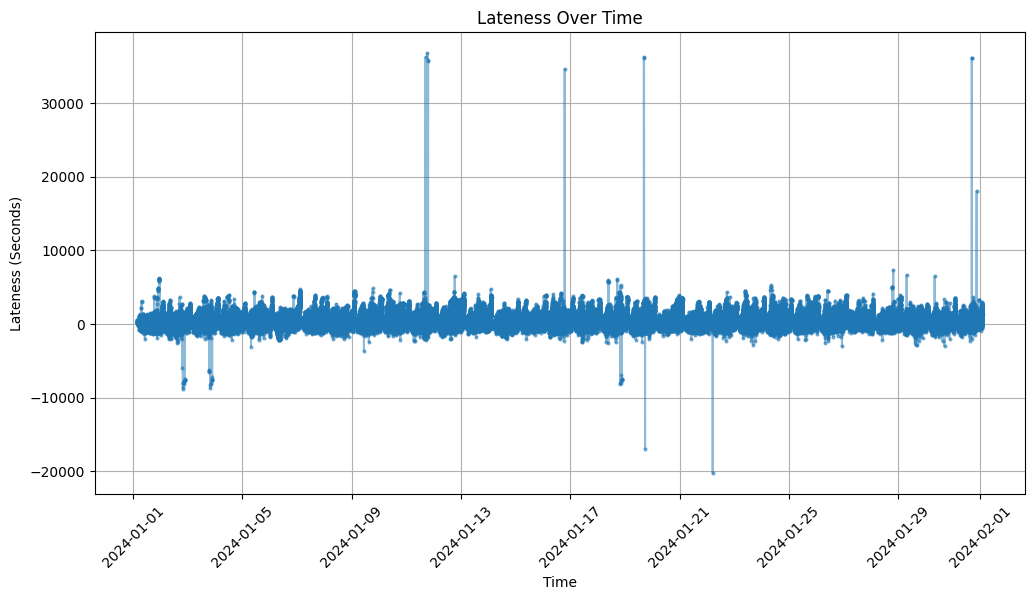

In [10]:
lateness_df = pd.DataFrame({"timestamp": timestamps, "lateness": lateness_over_time})
lateness_df = lateness_df.sort_values(by="timestamp")
plt.figure(figsize=(12, 6))
plt.plot(lateness_df["timestamp"], lateness_df["lateness"], linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Lateness (Seconds)")
plt.title("Lateness Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
outliers_df = lateness_df[lateness_df["lateness"].abs() > 3600].reset_index()
outlier_indices = set(outliers_df["index"].values)
original_outlier_rows = [] 
for csv_file in csv_files:
    print(f"Processing {csv_file} for outliers in chunks...")

    for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
        # Identify rows in the chunk that match the outlier indices
        matching_rows = chunk.loc[chunk.index.isin(outlier_indices)]

        if not matching_rows.empty:
            original_outlier_rows.append(matching_rows)

final_outlier_data = pd.concat(original_outlier_rows, ignore_index=True)
final_outlier_data

Processing MBTA-Bus-Arrival-Departure-Times_2024-01.csv for outliers in chunks...


,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway
0,2024-01-01,104,Inbound,61825411.0,5354,glndl,3,Midpoint,Schedule,1900-01-01T17:24:00Z,1900-01-01T18:26:17Z,NaN,NaN
1,2024-01-01,104,Inbound,61825411.0,5496,evrtc,4,Midpoint,Schedule,1900-01-01T17:28:00Z,1900-01-01T18:28:53Z,NaN,NaN
2,2024-01-01,111,Inbound,61825681.0,12003,ruthf,8,Midpoint,Headway,1900-01-01T20:08:00Z,1900-01-01T21:08:12Z,600.0,801.0
3,2024-01-01,111,Inbound,61825683.0,5547,woodc,1,Startpoint,Headway,1900-01-01T20:53:00Z,1900-01-01T22:31:18Z,660.0,675.0
4,2024-01-01,111,Inbound,61825683.0,5592,garfi,2,Midpoint,Headway,1900-01-01T20:55:00Z,1900-01-01T22:35:13Z,660.0,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,2024-01-30,240,Outbound,62131576.0,4177,mfran,8,Midpoint,Schedule,1900-01-01T06:18:00Z,1900-01-01T08:06:20Z,NaN,NaN
448,2024-01-31,04,Inbound,62134978.0,6564,sosta,3,Midpoint,Schedule,1900-01-01T17:04:00Z,1900-01-01T18:04:55Z,NaN,NaN
449,2024-01-31,743,Outbound,62144692.0,12009,twtnn,6,Midpoint,Headway,1900-01-01T06:39:00Z,1900-01-01T16:41:42Z,720.0,701.0
450,2024-01-31,743,Outbound,62144692.0,7096,airbs,7,Midpoint,Headway,1900-01-01T06:41:00Z,1900-01-01T16:44:27Z,720.0,689.0


In [12]:
outliers_per_route = final_outlier_data["route_id"].value_counts().reset_index()
outliers_per_route.columns = ["route_id", "outlier_count"]
outliers_per_route.head(15)

,route_id,outlier_count
0,66,45
1,216,39
2,23,39
3,743,34
4,24,24
5,111,23
6,34E,21
7,32,21
8,28,20
9,210,15


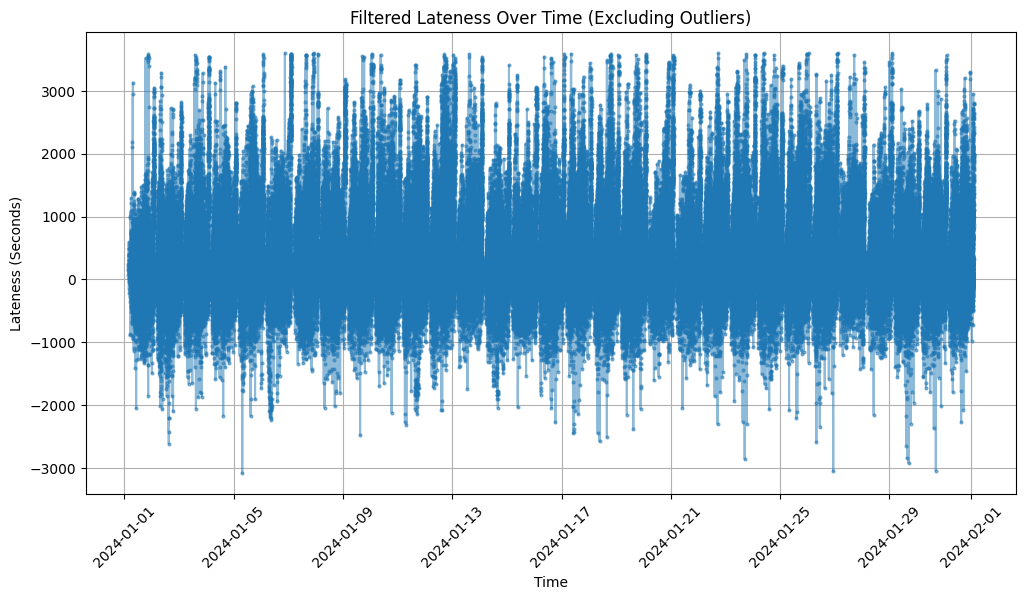

In [13]:
filtered_lateness_df = lateness_df[lateness_df["lateness"].abs() <= 3600]

plt.figure(figsize=(12, 6))
plt.plot(filtered_lateness_df["timestamp"], filtered_lateness_df["lateness"], linestyle='-', marker='o', markersize=2, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Lateness (Seconds)")
plt.title("Filtered Lateness Over Time (Excluding Outliers)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [14]:
total_lateness_results = []
count_results = []
lateness_over_time = []
timestamps = [] 
chunk_size = 500000
total_lateness = 0
num_rows = 0
outlier = 3600 # 1 hour in seconds
for csv_file in csv_files:
    month = csv_file.split("_")[-1].split(".")[0] 

    print(f"Processing {csv_file} in chunks...")

    # Check what data looks like
    # print(df.head())

    # Check the types
    # print(df.dtypes)

    # Process file in chunks with tqdm progress bar
    for chunk_idx, chunk in enumerate(tqdm(pd.read_csv(csv_file, chunksize=chunk_size), desc=f"Processing {month}")):
        # Convert datetime columns
        chunk["service_date"] = pd.to_datetime(chunk["service_date"]).dt.tz_localize(None)
        chunk["scheduled"] = pd.to_datetime(chunk["scheduled"]).dt.tz_localize(None)
        chunk["actual"] = pd.to_datetime(chunk["actual"]).dt.tz_localize(None)

        reference_time = pd.Timestamp("1900-01-01 00:00:00").tz_localize(None)

        chunk["scheduled_seconds"] = (chunk["scheduled"] - reference_time).dt.total_seconds()
        chunk["actual_seconds"] = (chunk["actual"] - reference_time).dt.total_seconds()

        chunk["scheduled"] = chunk["service_date"] + pd.to_timedelta(chunk["scheduled_seconds"], unit="s")
        chunk["actual"] = chunk["service_date"] + pd.to_timedelta(chunk["actual_seconds"], unit="s")

        # We ignore earliness as there is no indication of what it means and how it's calculated 
        # in the source (i.e. being late gives positive earliness scores sometimes but usually negative)
        chunk = chunk.drop(columns=["service_date"])

        # calculate our own lateness score which is just in seconds
        chunk["lateness"] = (chunk["actual"] - chunk["scheduled"]).dt.total_seconds()
        chunk = chunk[chunk["lateness"].abs() <= outlier]

        total_lateness_per_route = chunk.groupby("route_id", as_index=False)["lateness"].sum()

        total_lateness_per_route["month"] = month
        total_lateness_results.append(total_lateness_per_route)

        route_counts = chunk.groupby("route_id", as_index=False).size()
        route_counts["month"] = month
        count_results.append(route_counts)

        lateness_over_time.extend(chunk["lateness"].values)
        timestamps.extend(chunk["actual"].values)


Processing MBTA-Bus-Arrival-Departure-Times_2024-01.csv in chunks...


Processing 2024-01: 5it [00:18,  3.61s/it]


In [15]:
final_total_lateness_chunks = pd.concat(total_lateness_results, ignore_index=True)
final_counts_chunks = pd.concat(count_results, ignore_index=True)

final_total_lateness = final_total_lateness_chunks.groupby(["route_id", "month"], as_index=False)["lateness"].sum()
final_counts = final_counts_chunks.groupby(["route_id", "month"], as_index=False).sum()
final_summary = final_total_lateness.merge(final_counts, on=["route_id", "month"], how="left")
final_summary["average_lateness"] = final_summary["lateness"] / final_summary["size"]

final_summary.to_csv("final_summary.csv", index=False)
